<a href="https://colab.research.google.com/github/abmmatthew/dashboards/blob/master/Session1_TimeSeriesAnalysisAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Homework: Exploration of the Bay Area Rapid Transit (BART) data

Bay Area Rapid Transit (BART) is a rapid transit public transportation system serving the San Francisco Bay Area in California. The provided dataset includes daily total ridership records in 2017, 2018, and 2019. In this homework, we aim to use trend + seasonality linear regression to predict BART ridership and detect anomalies using the timeseries decomposition method.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

#import seaborn as sns
#sns.set()

%matplotlib inline

In [3]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv')

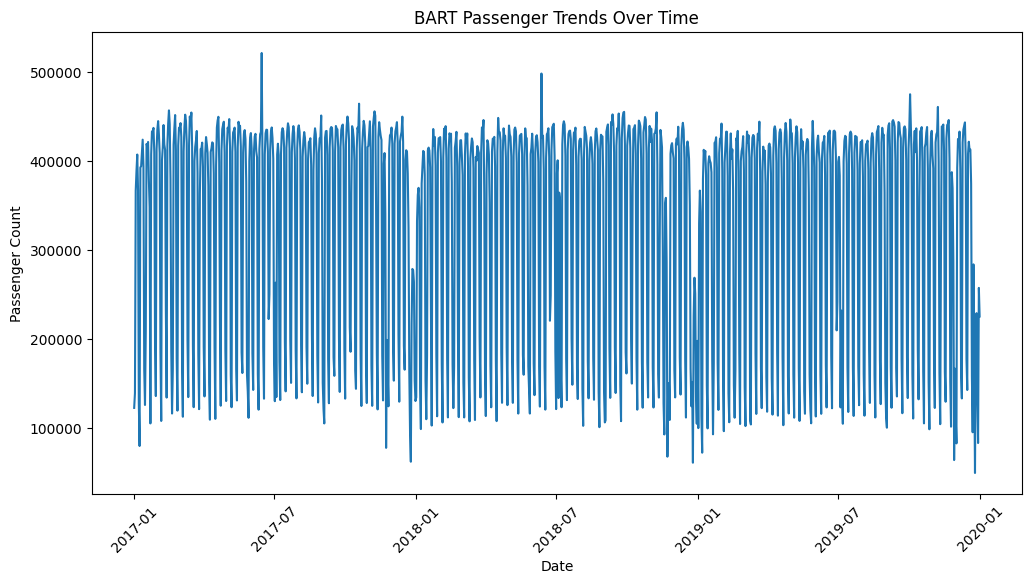

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
bart = bart.sort_values(by='date')
plt.figure(figsize=(12, 6))
plt.plot(bart['date'], bart['passenger'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.title("BART Passenger Trends Over Time")
plt.show()


Task 1

    use linear regression on time in days to explore the trends over 3 years of data availability, and report if there is a statistically significant trend in the BART data.

    Hint: use the index to represent the day count from the first day of the period.


In [10]:
import pandas as pd

# Try loading again
url = 'https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv'
bart = pd.read_csv(url)

# Check if it loaded correctly
print(bart.head())


         date  passenger
0  2017-01-01     122773
1  2017-01-02     139245
2  2017-01-03     366495
3  2017-01-04     388842
4  2017-01-05     407099


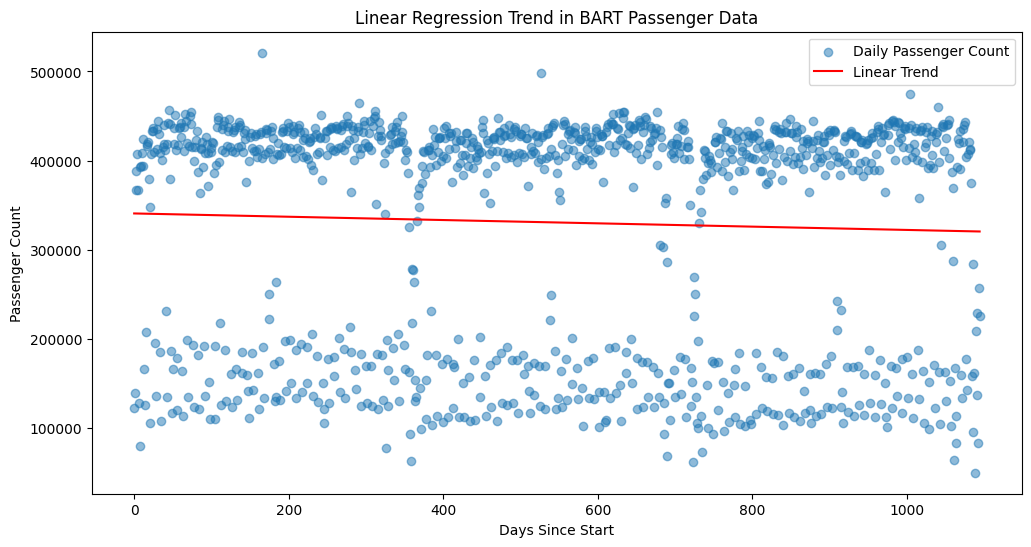

In [11]:
!pip install pandas matplotlib statsmodels --quiet
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
url = 'https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv'
bart = pd.read_csv(url)
bart['date'] = pd.to_datetime(bart['date'], errors='coerce')
bart = bart.dropna(subset=['date', 'passenger'])
bart = bart.sort_values(by='date')
bart['day_count'] = (bart['date'] - bart['date'].min()).dt.days
X = sm.add_constant(bart['day_count'])  # Add constant for intercept
Y = bart['passenger']

model = sm.OLS(Y, X).fit()

plt.figure(figsize=(12, 6))
plt.scatter(bart['day_count'], bart['passenger'], alpha=0.5, label="Daily Passenger Count")
plt.plot(bart['day_count'], model.predict(X), color='red', label="Linear Trend")
plt.xlabel("Days Since Start")
plt.ylabel("Passenger Count")
plt.title("Linear Regression Trend in BART Passenger Data")
plt.legend()
plt.show()

The trend line appears slightly downward, suggesting a small decline in ridership over time.

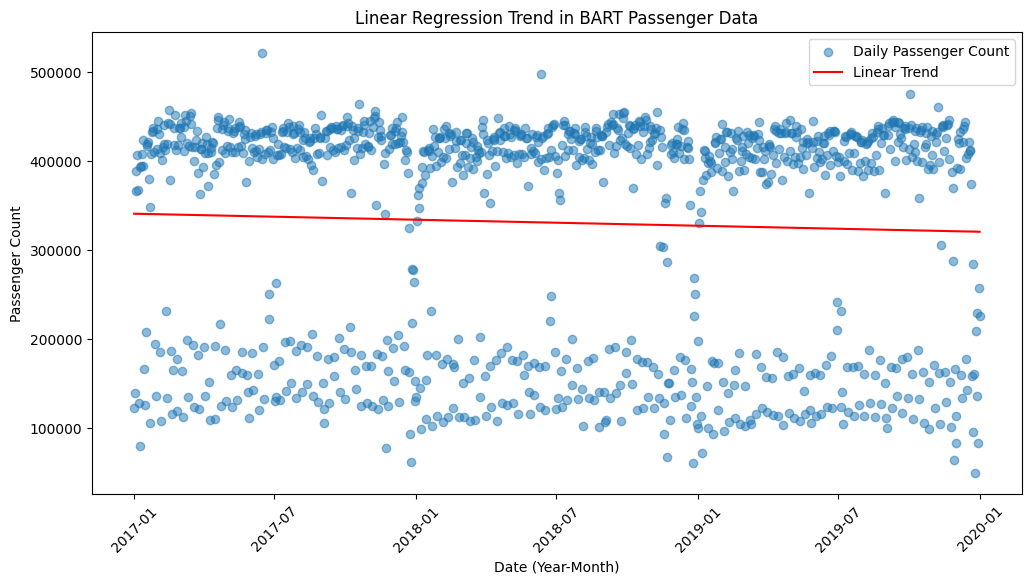

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.272
Date:                Sat, 08 Feb 2025   Prob (F-statistic):              0.132
Time:                        18:58:22   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.407e+05   7754.413     43.936      0.0

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
url = 'https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv'
bart = pd.read_csv(url)
bart['date'] = pd.to_datetime(bart['date'], errors='coerce')
bart = bart.dropna(subset=['date', 'passenger'])
bart['day_count'] = (bart['date'] - bart['date'].min()).dt.days
X = sm.add_constant(bart['day_count'])  # Add constant for intercept
Y = bart['passenger']
model = sm.OLS(Y, X).fit()
plt.figure(figsize=(12, 6))
plt.scatter(bart['date'], bart['passenger'], alpha=0.5, label="Daily Passenger Count")
plt.plot(bart['date'], model.predict(X), color='red', label="Linear Trend")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
plt.xlabel("Date (Year-Month)")
plt.ylabel("Passenger Count")
plt.title("Linear Regression Trend in BART Passenger Data")
plt.legend()
plt.show()
print(model.summary())


Task 2 Find a proper period using scipy.signal.periodogram and autocorrelation

Compare results of the two approaches, analyze if there is a consensus between the two?


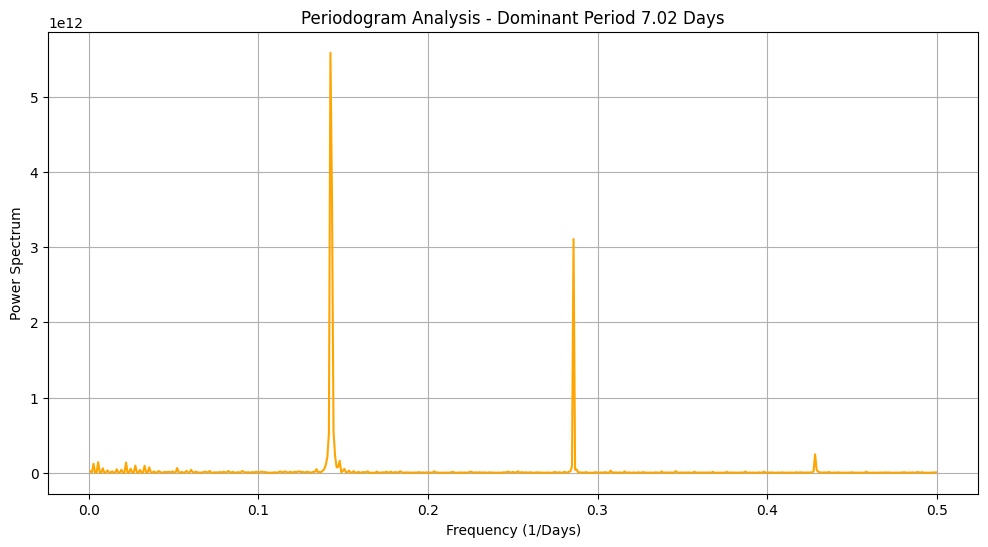

In [13]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
url = 'https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv'
bart = pd.read_csv(url)
bart['date'] = pd.to_datetime(bart['date'], errors='coerce')
bart = bart.dropna(subset=['date', 'passenger'])
bart['passenger'] = pd.to_numeric(bart['passenger'], errors='coerce')
passenger_counts = bart['passenger'].values

# Method 1: Using Periodogram (Fourier Analysis)
fs = 1
frequencies, power_spectrum = signal.periodogram(passenger_counts, fs)
dominant_period = 1 / frequencies[np.argmax(power_spectrum)]
plt.figure(figsize=(12, 6))
plt.plot(frequencies[1:], power_spectrum[1:], color='orange')  # Ignore zero frequency component
plt.xlabel('Frequency (1/Days)')
plt.ylabel('Power Spectrum')
plt.title('Periodogram Analysis - Dominant Period {:.2f} Days'.format(dominant_period))
plt.grid()
plt.show()

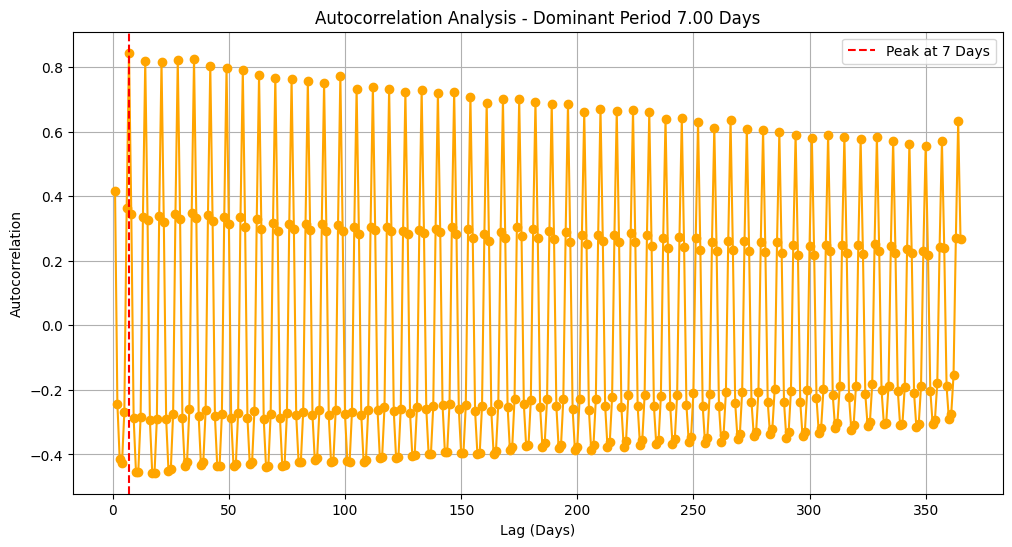

In [16]:
#Method 2: Using Autocorrelation Function (ACF)
acf_values = acf(passenger_counts, nlags=365)
dominant_lag = np.argmax(acf_values[1:]) + 1
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(acf_values)), acf_values[1:], marker="o", linestyle="-", color='orange')
plt.axvline(dominant_lag, color='red', linestyle="--", label=f"Peak at {dominant_lag} Days")
plt.xlabel("Lag (Days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Analysis - Dominant Period {:.2f} Days".format(dominant_lag))
plt.legend()
plt.grid()
plt.show()

In [20]:
# Comparing Results
print(f"🟠 Periodogram Dominant Period: {dominant_period:.2f} days")
print(f"🔴 Autocorrelation Dominant Lag: {dominant_lag:.2f} days")
if abs(dominant_period - dominant_lag) < 1:
    print("\n✅ Both methods confirm a weekly cycle (~7 days) in BART ridership.")
else:
    print("\n⚠️ There is some discrepancy between the two methods. Further analysis may be needed.")

🟠 Periodogram Dominant Period: 7.02 days
🔴 Autocorrelation Dominant Lag: 7.00 days

✅ Both methods confirm a weekly cycle (~7 days) in BART ridership.



Task 3 Build a linear regression for trend+seasonality (using time in days as a trend variable plus 7 dummy variables for each day of the week for a weekly period) to model the daily passenger count.

Train the model on years 2017 and 2018, test on 2019. Visualize the coefficients for each day of the week and analyze their statistical significance - use an errorbar plot with coefficient estimates + confidence intervals


In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
url = 'https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv'
bart = pd.read_csv(url)
bart['date'] = pd.to_datetime(bart['date'], errors='coerce')
bart = bart.dropna(subset=['date', 'passenger'])
bart['passenger'] = pd.to_numeric(bart['passenger'], errors='coerce')
bart['day_count'] = (bart['date'] - bart['date'].min()).dt.days
bart['day_of_week'] = bart['date'].dt.dayofweek
day_dummies = pd.get_dummies(bart['day_of_week'], prefix='day')
bart_model = pd.concat([bart[['date', 'passenger', 'day_count']], day_dummies], axis=1)

train_data = bart_model[(bart_model['date'].dt.year >= 2017) & (bart_model['date'].dt.year <= 2018)]
test_data = bart_model[bart_model['date'].dt.year == 2019]

X_train = sm.add_constant(train_data[['day_count'] + list(day_dummies.columns)])

X_train = X_train.astype(float)
Y_train = train_data['passenger']
X_test = sm.add_constant(test_data[['day_count'] + list(day_dummies.columns)])

X_test = X_test.astype(float)
Y_test = test_data['passenger']
model = sm.OLS(Y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     512.6
Date:                Sat, 08 Feb 2025   Prob (F-statistic):          3.58e-275
Time:                        19:17:12   Log-Likelihood:                -8961.8
No. Observations:                 730   AIC:                         1.794e+04
Df Residuals:                     722   BIC:                         1.798e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.99e+05   3378.343     88.494      0.0

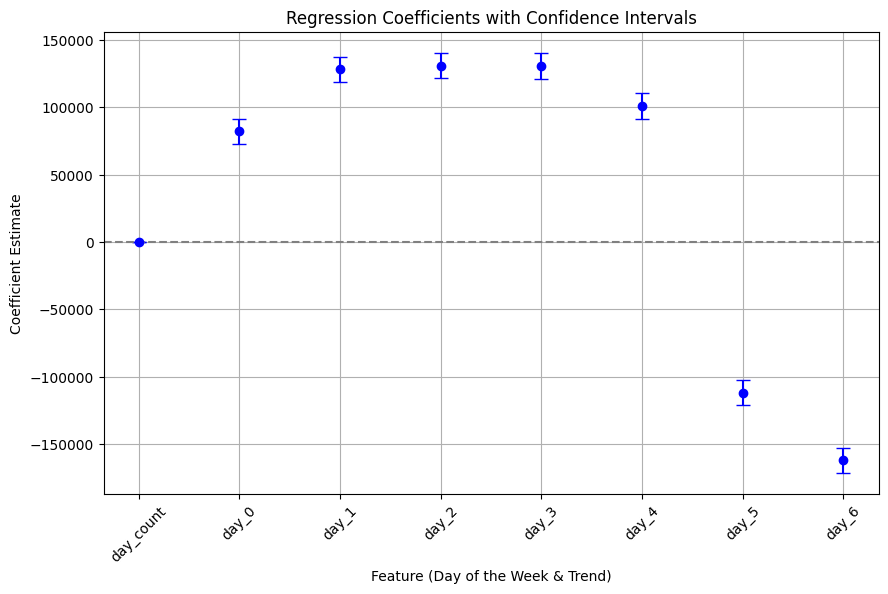

Test Set R²: 0.8325
Test Set RMSE: 55631.40


In [25]:
coefficients = model.params[1:]
conf_int = model.conf_int().iloc[1:]
plt.figure(figsize=(10, 6))
plt.errorbar(coefficients.index, coefficients.values,
             yerr=(conf_int[1] - conf_int[0]) / 2, fmt='o', capsize=5, color='b')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.xlabel("Feature (Day of the Week & Trend)")
plt.ylabel("Coefficient Estimate")
plt.title("Regression Coefficients with Confidence Intervals")
plt.grid()

plt.show()

# ------------------------------
# Model Performance on Test Set
# ------------------------------
Y_pred = model.predict(X_test)

# Compute R² and RMSE
r2_score = model.rsquared
rmse = np.sqrt(np.mean((Y_test - Y_pred) ** 2))

print(f"Test Set R²: {r2_score:.4f}")
print(f"Test Set RMSE: {rmse:.2f}")

Task 4, plot results and report in-sample (2017-2018) and out-of-sample (2019) predictions

(Show data and predictions on the same plot, use different colors for the data and in-sample/out-of sample model predictions). Print in-sample and out-of-sample R^2


In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
url = 'https://raw.githubusercontent.com/CUSP2022ADS/Data/main/bart.csv'
bart = pd.read_csv(url)
bart['date'] = pd.to_datetime(bart['date'], errors='coerce')
bart = bart.dropna(subset=['date', 'passenger'])
bart['passenger'] = pd.to_numeric(bart['passenger'], errors='coerce')
bart['day_count'] = (bart['date'] - bart['date'].min()).dt.days
bart['day_of_week'] = bart['date'].dt.dayofweek ##(0=Monday, ..., 6=Sunday)
day_dummies = pd.get_dummies(bart['day_of_week'], prefix='day')
bart_model = pd.concat([bart[['date', 'passenger', 'day_count']], day_dummies], axis=1)
train_data = bart_model[(bart_model['date'].dt.year >= 2017) & (bart_model['date'].dt.year <= 2018)]
test_data = bart_model[bart_model['date'].dt.year == 2019]
X_train = sm.add_constant(train_data.drop(columns=['date', 'passenger']))  # Add intercept
# Ensure all columns in X_train are numeric
X_train = X_train.astype(float)
Y_train = train_data['passenger']
X_test = sm.add_constant(test_data.drop(columns=['date', 'passenger']))  # Add intercept
# Ensure all columns in X_test are numeric
X_test = X_test.astype(float)
Y_test = test_data['passenger']
model = sm.OLS(Y_train, X_train).fit()
train_data['predicted'] = model.predict(X_train)
test_data['predicted'] = model.predict(X_test)
r2_in_sample = r2_score(Y_train, train_data['predicted'])
r2_out_sample = r2_score(Y_test, test_data['predicted'])
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

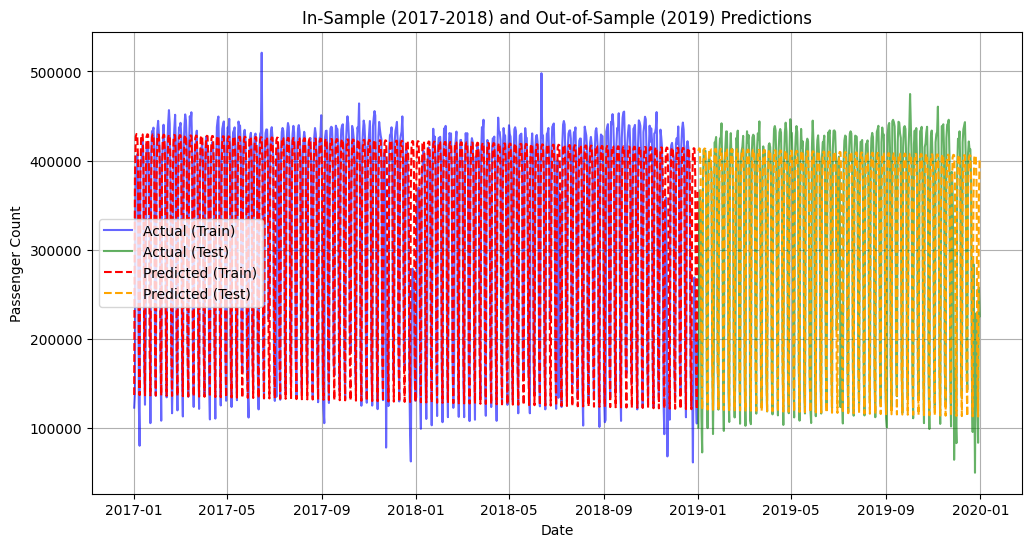

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['passenger'], label="Actual (Train)", color='blue', alpha=0.6)
plt.plot(test_data['date'], test_data['passenger'], label="Actual (Test)", color='green', alpha=0.6)
plt.plot(train_data['date'], train_data['predicted'], label="Predicted (Train)", color='red', linestyle='dashed')
plt.plot(test_data['date'], test_data['predicted'], label="Predicted (Test)", color='orange', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.title("In-Sample (2017-2018) and Out-of-Sample (2019) Predictions")
plt.legend()
plt.grid()
plt.show()

In [31]:
print(f"📊 In-Sample (2017-2018) R²: {r2_in_sample:.4f}")
print(f"📊 Out-of-Sample (2019) R²: {r2_out_sample:.4f}")

📊 In-Sample (2017-2018) R²: 0.8325
📊 Out-of-Sample (2019) R²: 0.8203
